In [1]:
#Setup
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import time

In [2]:
#Code from homeworks 3 & 4

#Calculate square distances -- should be correct
def calcSqDistances(X, Kmus):
    N, D = X.shape
    Out = np.zeros((N, Kmus.shape[0]), dtype = float) # Shape: (N, 4)
    for i in range(N): 
        for j in range(Kmus.shape[0]): 
            Out[i][j] = np.linalg.norm(X[i] - Kmus[j])**2
    return Out


#Determine R_nk -- should be correct
def determineRnk(sqDmat):
    N, K = sqDmat.shape
    Out = np.zeros((N,K))
    
    for i in range(N):
        m = np.argmin(sqDmat[i])
        Out[i,m] = 1       
    return Out


#Recalculate Mus -- still looking over
# def recalcMus(X, Rnk):
#     N, D = X.shape     # Shape: (N, 16)
#     N, J = Rnk.shape   # Shape: (N, K)
#     Kmus = np.zeros((J,D), dtype = float)   # Shape: (K, D)
    
#     # For each cluster
#     for i in range(J):
#         topTotal = 0
#         botTotal = 0
#         # For each datapoint
#         for j in range(N):
#             top = np.dot(Rnk[j,i], X[j])
#             bot = Rnk[j,i]
#             topTotal += top 
#             botTotal += bot
# #             print(f"Top total: {topTotal}")
# #             print(f"Bot total: {botTotal}")
#             value = topTotal / botTotal
            
#         Kmus[i,:] = value         
            
#     return Kmus

# recalculates mu values based on cluster assignments
# returns a 2-D numpy array consisting of the coordinates of the new clusters
def recalcMus(X, Rnk):
    Kmus = np.zeros((Rnk.shape[1], X.shape[1])) # shape: (K, 16)
    n_count = [0]*Rnk.shape[1]                  # counts the number of data points in each cluster
    
    for k in range(Rnk.shape[1]): # iterates over k clusters
        # at each index of the responsibility matrix, check if data point i is in cluster k
        # sums datapoints belonging to cluster k, and increments counter to track how many data points are in cluster k
        for i in range(len(X)):
            if Rnk[i][k] == 1:
                Kmus[k] = np.add(Kmus[k], X[i])
                n_count[k] += 1
            else:
                continue
    for i in range(len(Kmus)):
        Kmus[i] = np.divide(Kmus[i], n_count[i])
    return Kmus

#Provided function - plotCurrent
def plotCurrent(X, Rnk, Kmus):
    N, D = X.shape
    K = Kmus.shape[0]

    InitColorMat = np.array([[1, 0, 0],
                             [0, 1, 0],
                             [0, 0, 1],
                             [0, 0, 0],
                             [1, 1, 0],
                             [1, 0, 1],
                             [0, 1, 1]])

    KColorMat = InitColorMat[0:K,:]

    colorVec = np.dot(Rnk, KColorMat)
    muColorVec = np.dot(np.eye(K), KColorMat)
    plt.scatter(X[:,0], X[:,1], c=colorVec)

    plt.scatter(Kmus[:,0], Kmus[:,1], s=200, c=muColorVec, marker='d')
    plt.axis('equal')
    plt.show()

#Provided function - runKMeans
def runKMeans(K,X):
    #load data file specified by fileString from Bishop book
#     X = np.loadtxt(fileString, dtype='float')

    #determine and store data set information
    N, D = X.shape

    #allocate space for the K mu vectors
    Kmus = np.zeros((K, D))

    #initialize cluster centers by randomly picking points from the data
    rand_inds = np.random.permutation(N)
    Kmus = X[rand_inds[0:K],:]

    #specify the maximum number of iterations to allow
    maxiters = 1000

    for iter in range(maxiters):
        #assign each data vector to closest mu vector as per Bishop (9.2)
        #do this by first calculating a squared distance matrix where the n,k entry
        #contains the squared distance from the nth data vector to the kth mu vector

        #sqDmat will be an N-by-K matrix with the n,k entry as specfied above
        sqDmat = calcSqDistances(X, Kmus)

        #given the matrix of squared distances, determine the closest cluster
        #center for each data vector

        #R is the "responsibility" matrix
        #R will be an N-by-K matrix of binary values whose n,k entry is set as
        #per Bishop (9.2)
        #Specifically, the n,k entry is 1 if point n is closest to cluster k,
        #and is 0 otherwise
        Rnk = determineRnk(sqDmat)

        KmusOld = Kmus
        time.sleep(1)

        #recalculate mu values based on cluster assignments as per Bishop (9.4)
        Kmus = recalcMus(X, Rnk)

        #check to see if the cluster centers have converged.  If so, break.
        if np.sum(np.abs(KmusOld.reshape((-1, 1)) - Kmus.reshape((-1, 1)))) < 1e-6:
#             print(iter)
            break

    return Kmus

#Sambaran's gaussian function from Discussion
def gaussian(x, mu, cov):
    l,m = np.shape(cov)
    constant = .001*np.identity(l)
    cov = cov+constant
    d = np.shape(x)[1]
    mu = mu[None, :]
    dr = 1 / (np.sqrt((2 * np.pi) ** (d) * np.linalg.det(cov)))
    nr = (np.exp(-np.diag((x - mu)@(np.linalg.pinv(cov))@((x - mu).T)/2)))
    
    return nr * dr

#Calculate responsibility
# def calcRespons(x, pi, mu, cov):
    
#     top = np.zeros((x.shape[0], 2))
#     for i in range(2):
#         top[:,i] = pi[i] * gaussian(x, mu[i], np.diag(cov[i]))
#     bot = np.sum(top, axis = 1, keepdims = True)
#     return np.divide(top, bot)

def calcRespons(X, N, K, pi, mu, sigma):
    respons = np.zeros((N, K), dtype=float)
    for cluster in range(K):
        respons[:, cluster] = gaussian(X, mu[cluster], sigma[cluster]) * pi[cluster]
    
    respons = np.divide(respons, np.sum(respons, axis=1, keepdims=True))
    
    return respons
    
#Tweaking runKMeans to get runGMM
def runGMM(K,X, pi_in, mu_in, var_in):
    N, D = X.shape
    
    mu = mu_in
    pi = pi_in
    var = var_in

    #100 maximum iterations
    maxiters = 10
    for iter in range(maxiters):        
        print(f"Current iter: {iter}")
        #Get gamma using calcRespons
        print(f"Pi: {pi}", "\n")
        print(f"Mu: {mu}", "\n")
        print(f"Var: {var}", "\n")
        gamma = calcRespons(X, N, K, pi, mu, var)
#         print(f"Passed gamma @ iter: {iter}")
        
        # Plot current iter
        plotCurrent(X, gamma, mu)
        
        #Determine pi using gamma
        new_pi = np.sum(gamma, axis=0) / N
#         print(f"Passed pi @ iter: {iter}")
        
        #Determine mus
        new_mu = np.divide(gamma.T @ X, np.sum(gamma, axis=0, keepdims=True).T) 
#         print(f"Passed mu @ iter: {iter}")
        
        #Determine variances       
        temp_var = np.zeros((K,D)) 
        for cluster in range(K):
            temp_var[cluster] = np.divide(gamma[:,cluster].T @ ((X - new_mu[cluster])*((X - new_mu[cluster]))), np.sum(gamma[:,cluster]))
    
        new_var = np.zeros((K, D, D))
        for i in range(K):
            new_var[i] = np.diag(temp_var[i])
            
        #check to see if the cluster centers have converged.  If so, break.
        if np.sum(np.abs(new_mu.reshape((-1, 1)) - mu.reshape((-1, 1)))) < 1e-2:
            print(iter)
            plotCurrent(X, gamma, mu)
            break
                
        mu, pi, var = new_mu, new_pi, new_var
        
                
    return new_pi, new_mu, new_var

In [3]:
thing = pd.read_csv('Training_Set.csv', delimiter=',', header = None)
thing = np.asarray(thing, dtype = float)

In [4]:
test = thing[:10]

In [5]:
# Original code from notebook -- not using

# #Initialization parameters
# muOld = runKMeans(4, thing) 
# piKOld = np.asarray([1/4]*4)
# covOld = np.zeros((4,4))
# for i in range(len(covOld)):
#     covOld[i] = np.asarray([4,5])

# #Find GMM
# runGMM(4, thing, piOld, muOld, covOld)

In [6]:
test.shape

(10, 16)

Current iter: 0
Pi: [0.25 0.25 0.25 0.25] 

Mu: [[16.         21.         14.         11.         20.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 9.75        8.75        9.75       21.25        1.75        4.5
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 9.          5.         18.66666667  6.          3.33333333 14.66666667
  14.          5.33333333  4.          3.          1.          2.66666667
   3.66666667  1.66666667  3.          6.66666667]
 [19.         23.          6.5         1.          7.5         6.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]] 

Var: [[[ 1.  0.  0. ...  0.  0.  0.]
  [ 0.  2.  0. ...  0.  0.  0.]
  [ 0.  0.  3. ...  0.  0.  0.]
  ...
  [ 0.  0.  0. ... 14.  0.  0.]
  [ 0.  0.  0. ...  0. 15.  0.]
  [ 0.  0.  0. ...  0.  0. 16

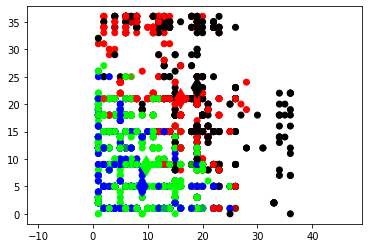

Current iter: 1
Pi: [0.17973538 0.39752993 0.2362283  0.18650638] 

Mu: [[1.45155608e+01 1.89189162e+01 1.42490034e+01 1.12104083e+01
  1.39569581e+01 4.02832260e+00 3.13450679e+00 1.60949007e+00
  8.63912322e-01 5.71810613e-01 3.37681581e-01 1.29564063e-01
  3.08690969e-02 4.09023091e-02 1.43873971e-66 3.19719935e-66]
 [9.75842907e+00 9.13684385e+00 1.01847091e+01 1.47481600e+01
  5.45954725e+00 3.78148294e+00 1.54783957e+00 8.86958733e-01
  4.98304302e-01 1.64526664e-01 1.11478550e-01 1.60544697e-02
  1.37139201e-02 4.77550161e-03 5.86936393e-37 1.30430310e-36]
 [8.75863839e+00 7.17854764e+00 1.71824000e+01 6.13548254e+00
  7.84641133e+00 8.52363328e+00 5.60578851e+00 3.44523597e+00
  2.14873545e+00 1.25867741e+00 5.81339403e-01 2.81507428e-01
  1.19587813e-01 2.22242717e-02 3.06906493e-02 2.11659651e-02]
 [1.88987322e+01 1.85712481e+01 9.01311787e+00 5.23243928e+00
  3.61951634e+00 3.74888948e+00 1.63297230e+00 8.04330621e-01
  3.31309758e-01 1.55415044e-01 5.71658215e-02 1.91982666

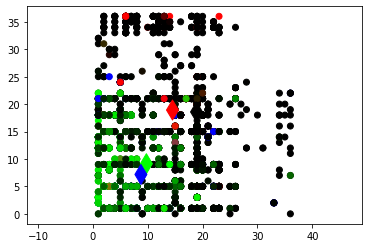

Current iter: 2
Pi: [0.03993693 0.19805187 0.05130804 0.71070316] 

Mu: [[1.20126969e+01 1.57457869e+01 1.43554995e+01 1.31054685e+01
  1.74720795e+01 9.94903507e+00 1.21428861e+01 1.02789993e+01
  5.07802859e+00 1.10127172e+00 4.59948131e-01 3.12957964e-01
  8.13783170e-02 2.25355339e-01 0.00000000e+00 0.00000000e+00]
 [7.15669759e+00 8.62019717e+00 1.31604359e+01 1.67582750e+01
  9.57857862e+00 5.48421570e+00 2.31501749e+00 1.59062476e+00
  4.23909222e-01 1.25936827e-03 4.78844155e-04 4.07247457e-24
  4.78732486e-82 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.07259844e+01 1.04674595e+01 1.41002971e+01 1.17210002e+01
  1.16766840e+01 1.30866401e+01 1.22709112e+01 1.11304793e+01
  1.20707110e+01 8.75434538e+00 4.57113754e+00 1.70054077e+00
  7.01644368e-01 1.07195667e-01 1.41303380e-01 9.74506067e-02]
 [1.35563252e+01 1.31121559e+01 1.18847479e+01 8.24425573e+00
  5.64730234e+00 3.91873456e+00 1.73695646e+00 4.34962211e-01
  2.34536122e-02 1.54893542e-03 1.73301802e-07 2.20572101

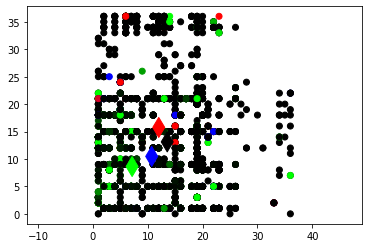

Current iter: 3
Pi: [0.03307613 0.10566263 0.02391905 0.83734219] 

Mu: [[1.07508729e+001 1.32795291e+001 1.32691606e+001 1.29099849e+001
  1.28371127e+001 1.13282594e+001 1.35845852e+001 1.06114451e+001
  1.39868023e+001 4.75419385e+000 5.38270356e-001 4.24472301e-001
  9.52894732e-002 2.64183023e-001 0.00000000e+000 0.00000000e+000]
 [9.48046140e+000 1.07121312e+001 1.35484783e+001 1.45925863e+001
  1.26475213e+001 1.10613166e+001 7.95436506e+000 9.13321602e+000
  1.74017109e+000 4.66945793e-040 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [1.24532754e+001 1.04880164e+001 1.39520010e+001 1.19150142e+001
  1.13997853e+001 1.28687964e+001 9.92833176e+000 9.59260600e+000
  1.15294608e+001 1.40996254e+001 9.83300268e+000 3.58334018e+000
  1.50918161e+000 2.40889493e-001 3.03105661e-001 2.09038387e-001]
 [1.24522589e+001 1.23844580e+001 1.21163978e+001 9.61267794e+000
  6.17890232e+000 3.68872830e+000 1.52890791e+000 7.19882676e-002
 

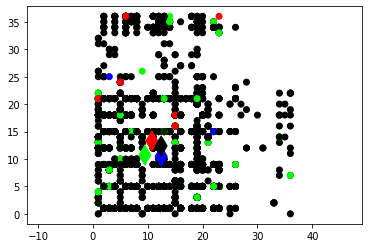

Current iter: 4
Pi: [0.02450755 0.1030769  0.01624315 0.8561724 ] 

Mu: [[1.09977129e+001 1.26782175e+001 1.41734136e+001 1.27360440e+001
  1.32541392e+001 1.13111731e+001 1.18551111e+001 1.15934283e+001
  1.14956373e+001 1.26385537e+001 7.68585868e-001 1.42323982e-001
  6.23774037e-007 1.74576014e-006 0.00000000e+000 0.00000000e+000]
 [1.08470663e+001 1.18136919e+001 1.32505636e+001 1.25070399e+001
  1.19150793e+001 1.23922442e+001 1.11597467e+001 1.12891480e+001
  4.46735718e+000 1.11355453e-213 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [1.30347524e+001 1.12998110e+001 1.39690353e+001 1.21206641e+001
  1.08772673e+001 1.34237502e+001 1.02482429e+001 9.22763930e+000
  1.11147645e+001 1.13746437e+001 1.44161637e+001 5.92631452e+000
  2.41640299e+000 8.92681619e-001 4.46342127e-001 3.07822156e-001]
 [1.22436388e+001 1.22405542e+001 1.21583763e+001 9.93352052e+000
  6.39803735e+000 3.69948011e+000 1.40180230e+000 9.44571572e-003
 

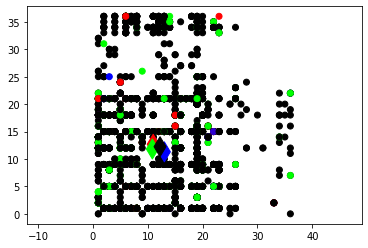

Current iter: 5
Pi: [0.02581984 0.1090034  0.01493017 0.85024659] 

Mu: [[1.09241812e+001 1.25591388e+001 1.43661305e+001 1.26013909e+001
  1.30900117e+001 1.13344704e+001 1.16021023e+001 1.15058732e+001
  1.14967471e+001 1.24582450e+001 1.53001839e+000 4.85050743e-002
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [1.10515107e+001 1.20437439e+001 1.33226783e+001 1.23955749e+001
  1.20896309e+001 1.20449975e+001 1.10564730e+001 1.07496642e+001
  4.22463783e+000 1.17761577e-213 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [1.33414090e+001 1.13846777e+001 1.36179924e+001 1.22995406e+001
  1.09521944e+001 1.35695643e+001 1.05448017e+001 9.17071132e+000
  1.10786386e+001 1.15758966e+001 1.42995838e+001 6.59722097e+000
  2.62890574e+000 9.71188107e-001 4.85594053e-001 3.34892451e-001]
 [1.22271559e+001 1.22140341e+001 1.21415161e+001 9.92987232e+000
  6.33720744e+000 3.68340701e+000 1.34702896e+000 6.11918074e-018
 

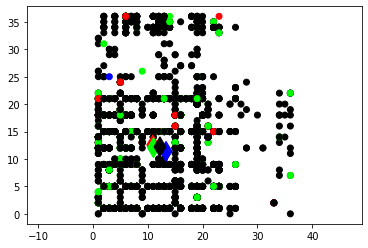

Current iter: 6
Pi: [0.03180946 0.10857031 0.00894055 0.85067968] 

Mu: [[1.10542933e+001 1.20729970e+001 1.43326931e+001 1.24202985e+001
  1.26231387e+001 1.18393847e+001 1.11062959e+001 1.09850040e+001
  1.12170624e+001 1.16890123e+001 4.42811740e+000 1.57180808e-002
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [1.10641509e+001 1.20537409e+001 1.33209000e+001 1.23773289e+001
  1.20973430e+001 1.20049163e+001 1.10173079e+001 1.07925447e+001
  4.24148964e+000 1.04791692e-213 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [1.44978777e+001 1.23274975e+001 1.32357522e+001 1.27416259e+001
  1.11810685e+001 1.32705113e+001 1.16004978e+001 9.45949055e+000
  1.17936197e+001 1.37216170e+001 1.25432971e+001 1.11011101e+001
  4.39011083e+000 1.62182438e+000 8.10912192e-001 5.59249788e-001]
 [1.22249442e+001 1.22126715e+001 1.21423444e+001 9.93345631e+000
  6.33915177e+000 3.69277944e+000 1.35697068e+000 3.47291899e-214
 

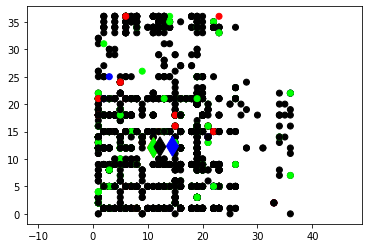

Current iter: 7
Pi: [0.03175463 0.10847848 0.00899541 0.85077148] 

Mu: [[1.10714970e+001 1.19529330e+001 1.43227804e+001 1.23867868e+001
  1.26606053e+001 1.16465098e+001 1.12122170e+001 1.09370792e+001
  1.10709029e+001 1.18808805e+001 4.63184800e+000 1.44534364e-004
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [1.10658056e+001 1.20565272e+001 1.33208543e+001 1.23724433e+001
  1.20998306e+001 1.19981837e+001 1.10073752e+001 1.08016784e+001
  4.24507677e+000 4.16349717e-214 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [1.44161435e+001 1.27497777e+001 1.32774330e+001 1.28579671e+001
  1.10576011e+001 1.39426481e+001 1.12235697e+001 9.63796892e+000
  1.23060672e+001 1.30318737e+001 1.17746031e+001 1.10884780e+001
  4.36333623e+000 1.61193313e+000 8.05966565e-001 5.55839010e-001]
 [1.22246080e+001 1.22122991e+001 1.21424774e+001 9.93434295e+000
  6.33945591e+000 3.69453481e+000 1.35927956e+000 3.51282763e-214
 

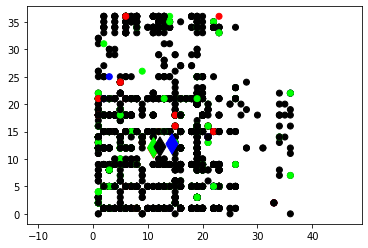

Current iter: 8
Pi: [0.03175013 0.10845717 0.009      0.8507927 ] 

Mu: [[1.10708631e+001 1.19527517e+001 1.43228317e+001 1.23858290e+001
  1.26614160e+001 1.16456665e+001 1.12125955e+001 1.09370019e+001
  1.10708762e+001 1.18818407e+001 4.62990214e+000 6.74875161e-181
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [1.10661091e+001 1.20572127e+001 1.33208680e+001 1.23712582e+001
  1.21004430e+001 1.19967820e+001 1.10049926e+001 1.08037926e+001
  4.24589940e+000 1.21207044e-214 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [1.44166667e+001 1.27500000e+001 1.32777778e+001 1.28611111e+001
  1.10555556e+001 1.39444444e+001 1.12222222e+001 9.63888889e+000
  1.23055556e+001 1.30277778e+001 1.17777778e+001 1.10833333e+001
  4.36111111e+000 1.61111111e+000 8.05555556e-001 5.55555556e-001]
 [1.22245405e+001 1.22122080e+001 1.21425050e+001 9.93455476e+000
  6.33952148e+000 3.69492069e+000 1.35982393e+000 3.52045147e-214
 

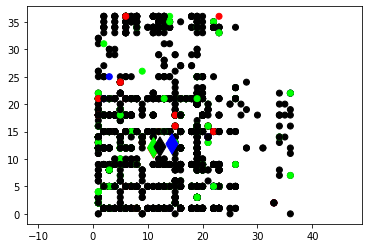

8


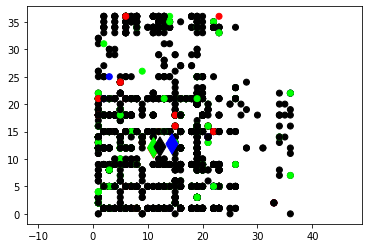

(array([0.03175014, 0.10845218, 0.009     , 0.85079768]),
 array([[1.10708629e+001, 1.19527514e+001, 1.43228315e+001,
         1.23858292e+001, 1.26614159e+001, 1.16456663e+001,
         1.12125954e+001, 1.09370014e+001, 1.10708769e+001,
         1.18818373e+001, 4.62990081e+000, 2.40851979e-208,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
         0.00000000e+000],
        [1.10661756e+001, 1.20573758e+001, 1.33208726e+001,
         1.23709770e+001, 1.21005886e+001, 1.19964621e+001,
         1.10044285e+001, 1.08042886e+001, 4.24609351e+000,
         1.13277574e-214, 0.00000000e+000, 0.00000000e+000,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
         0.00000000e+000],
        [1.44166667e+001, 1.27500000e+001, 1.32777778e+001,
         1.28611111e+001, 1.10555556e+001, 1.39444444e+001,
         1.12222222e+001, 9.63888889e+000, 1.23055556e+001,
         1.30277778e+001, 1.17777778e+001, 1.10833333e+001,
         4.36111111e+000, 1.61111111e+000, 8.055

In [7]:
#Initialization parameters
muOld = runKMeans(4, test) 
piOld = np.asarray([1/4]*4)
# covOld = np.zeros((4,4))
N, D = thing.shape
covOld = np.zeros((4, D, D))
d = []
for i in range(1,17):
    d.append(i)

for i in range(4):
    covOld[i] = np.diag(d)

#Find GMM
runGMM(4, thing, piOld, muOld, covOld)